In [2]:
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertModel, BertConfig
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

C:\Users\USER\AppData\Roaming\Python\Python38\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Init

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
configuration = BertConfig()
bert_model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states = True).to(device)
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', use_fast=True)
args = {
        "device" : device,
        "data_dir" : r'../data/filtered_reviews_with_split.pkl',
        "data_chunks_dir" : r'../data/chunks',
        "emb_dim" : 768,
        "max_word" : 25,
        "max_sentence" : 10,
        "max_group": 5, # exclude default group
        "max_review_user" : 20,
        "max_review_item" : 50,
        "epoch" : 5,
        "batch_size": 32,
        "bert_configuration" : configuration,
        "bert_model" : bert_model,
        "bert_tokenizer" : bert_tokenizer
    }

print("Device: ",device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Device:  cuda


## Read Pickle

In [4]:
"""
Required dataframe format:
[column name]       [dtype]
AppID               int
UserID              int
Like                int
Review              String
"""
data = pd.read_pickle(r'../data/reviews_38158.pkl')
# Change dtype of columns in df
data.reset_index(drop=True, inplace=True)
data["UserID"] = data["UserID"].astype("int64")
data["AppID"] = data["AppID"].astype(int)
data["Like"] = data["Like"].astype(int)
"""
TODO dataframe format:
[column name]       [dtype]
SplitReview         list
LDA_group           list
SplitReview_emb     np.array
"""
# TODO Columns
data["SplitReview"] = ""
data["SplitReview_emb"]= ""
data["LDA_group"]= ""

print(data.dtypes)
print("---Once you've prepared the data, press {Run All} will do the rest---")
data

AppID               int32
UserID              int64
Like                int32
Review             object
SplitReview        object
SplitReview_emb    object
LDA_group          object
dtype: object
---Once you've prepared the data, press {Run All} will do the rest---


,AppID,UserID,Like,Review,SplitReview,SplitReview_emb,LDA_group
0,730,76561197969379991,1,wingman is fun with friends.,,,
1,730,76561198118543045,0,"Awful, toxic community and annoying game play....",,,
2,730,76561197971801273,0,After playing Counterstrike: Source for 12000+...,,,
3,730,76561198084359238,1,Lots of fun to be had with this one. A lot of ...,,,
4,730,76561198123845513,0,[h1] This really doesn't have the feel of spor...,,,
...,...,...,...,...,...,...,...
38153,9160,76561197964009814,0,The most demonic and difficult user made level...,,,
38154,9160,76561197977081885,1,"More like, Masturbator Levels of Doom 2 AMIRIT...",,,
38155,9160,76561197993676094,1,Just some random lvls,,,
38156,9160,76561198010396848,1,additional levels for Doom 2.,,,


In [5]:
# check the number of reviews for each user/item 
app_reviews = data['AppID'].value_counts()
user_reviews = data['UserID'].value_counts()
app_reviews, user_reviews

(379720     372
 8870       320
 108710     274
 233270     252
 204100     250
           ... 
 911400      38
 245390      38
 356400      37
 1105500     37
 266010      36
 Name: AppID, Length: 485, dtype: int64,
 76561198046675266    199
 76561198062813911    197
 76561198161141911    142
 76561197970705552    138
 76561198027267313    131
                     ... 
 76561198020298884     30
 76561198088093310     30
 76561198034199687     30
 76561198260401907     30
 76561198271933086     30
 Name: UserID, Length: 882, dtype: int64)

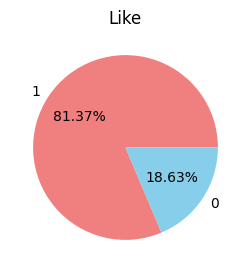

In [6]:
plt.figure(figsize=(3,3))
data['Like'].value_counts().plot( kind='pie', colors=['lightcoral','skyblue'], autopct='%1.2f%%' )
plt.title('Like')
plt.ylabel( '' )
plt.show()

# LDA Grouping

### 1. Split every review to sentences.  

In [7]:
import re

def review_to_sentences(review):
    """
    split review into sentences contained by a list
    param: review (String)
    output: sentences (list of word)
    """
    sentences = review.splitlines()
    sentences = list(filter(None, sentences))
    tmp = []
    for sent in sentences:
        sent = re.split(r' *[\.\?!][\'"\)\]]* *', sent)
        tmp.extend(sent)
    # delete sentence less than specific number of words
    sentences = list(filter(lambda x:len(x.split())>=5, tmp))
    return sentences

In [8]:
list_split_sentences =  [review_to_sentences(review) for review in data["Review"]]
data["SplitReview"] = list_split_sentences
empty = [i for i, x in enumerate(data["SplitReview"]) if x ==[]] # Delete data whose splitReview is empty list
data.drop(empty, axis=0, inplace=True)
data.reset_index(drop=True, inplace=True)
data

,AppID,UserID,Like,Review,SplitReview,SplitReview_emb,LDA_group
0,730,76561197969379991,1,wingman is fun with friends.,[wingman is fun with friends],,
1,730,76561198118543045,0,"Awful, toxic community and annoying game play....","[Awful, toxic community and annoying game play...",,
2,730,76561197971801273,0,After playing Counterstrike: Source for 12000+...,[After playing Counterstrike: Source for 12000...,,
3,730,76561198084359238,1,Lots of fun to be had with this one. A lot of ...,"[Lots of fun to be had with this one, A lot of...",,
4,730,76561198123845513,0,[h1] This really doesn't have the feel of spor...,[[h1] This really doesn't have the feel of spo...,,
...,...,...,...,...,...,...,...
37112,9160,76561197992120094,0,Let me know if you can get it to work. I can't.,[Let me know if you can get it to work],,
37113,9160,76561197964009814,0,The most demonic and difficult user made level...,[The most demonic and difficult user made leve...,,
37114,9160,76561197977081885,1,"More like, Masturbator Levels of Doom 2 AMIRIT...","[More like, Masturbator Levels of Doom 2 AMIRI...",,
37115,9160,76561198010396848,1,additional levels for Doom 2.,[additional levels for Doom 2],,


### 2. LDA Grouping
#### asign each given sentence a group

In [9]:
# Modify LDA part from 趙儀
def stemmer_with_delete_stopword(split_sentences):
    vectorizer = TfidfVectorizer(stop_words = "english")
    stop_list = list(vectorizer.get_stop_words())
    porter_stemmer = PorterStemmer()
    all_stem_sents=[]
    for review in split_sentences:
        review_stem_list = []
        for sent in review:
            sent_stem_list =[]
            for word in sent.split(" "):
                if len(word)>2:
                    if word not in stop_list:
                        sent_stem_list.append(porter_stemmer.stem(word))
            review_stem_list.append(sent_stem_list)
        all_stem_sents.append(review_stem_list) 
    return all_stem_sents

def LDAGrouping(reviews, groups):
    all_sents = []
    for review in reviews:
        for sentence in review:
            all_sents.append(sentence)
    dictionary = corpora.Dictionary(all_sents)
    corpus = [dictionary.doc2bow(sent) for sent in all_sents]
    lda = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=groups)
    group_results = []
    for sents in reviews:
        single_corpus = [dictionary.doc2bow(sent) for sent in sents]
        sents_group_result = []
        for scores in lda.inference(single_corpus)[0]:
            # scores.argmax()+1 --> Retain group:0 for no meaning sentences
            sents_group_result.append(scores.argmax()+1)
        group_results.append(sents_group_result)

    return group_results

def pad_and_trunc(group_results, *, max_sentence):
    #max number of sentences in a review
    result_list = []
    for i, result in enumerate(group_results):
        if len(result) >= max_sentence:
            result = result[:10]
        else:
            result.extend([0]*(max_sentence-len(result)))
        result_list.append(np.array(result).astype(int))
    return result_list

In [58]:
clean_reviews = stemmer_with_delete_stopword(data["SplitReview"].tolist())
group_list = LDAGrouping(clean_reviews, args["max_group"]) # Training might takes a little bit time 
pad_group_list = pad_and_trunc(group_list, max_sentence=args["max_sentence"])
data["LDA_group"] = pad_group_list
data

,AppID,UserID,Like,Review,SplitReview,SplitReview_emb,LDA_group
0,730,76561197969379991,1,wingman is fun with friends.,[wingman is fun with friends],,"[5, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,730,76561198118543045,0,"Awful, toxic community and annoying game play....","[Awful, toxic community and annoying game play...",,"[5, 3, 0, 0, 0, 0, 0, 0, 0, 0]"
2,730,76561197971801273,0,After playing Counterstrike: Source for 12000+...,[After playing Counterstrike: Source for 12000...,,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,730,76561198084359238,1,Lots of fun to be had with this one. A lot of ...,"[Lots of fun to be had with this one, A lot of...",,"[5, 5, 5, 5, 0, 0, 0, 0, 0, 0]"
4,730,76561198123845513,0,[h1] This really doesn't have the feel of spor...,[[h1] This really doesn't have the feel of spo...,,"[2, 2, 5, 5, 2, 4, 5, 5, 5, 1]"
...,...,...,...,...,...,...,...
37112,9160,76561197992120094,0,Let me know if you can get it to work. I can't.,[Let me know if you can get it to work],,"[4, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
37113,9160,76561197964009814,0,The most demonic and difficult user made level...,[The most demonic and difficult user made leve...,,"[3, 5, 0, 0, 0, 0, 0, 0, 0, 0]"
37114,9160,76561197977081885,1,"More like, Masturbator Levels of Doom 2 AMIRIT...","[More like, Masturbator Levels of Doom 2 AMIRI...",,"[4, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
37115,9160,76561198010396848,1,additional levels for Doom 2.,[additional levels for Doom 2],,"[3, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [59]:
# Save the LDA grouping result
data.to_pickle(r"../data/filtered_reviews_group.pkl")

# Split Train Val Test

In [60]:
# Split train/val/test data by user case
train_df, val_df, test_df = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
tain_ratio = 0.7
val_ratio = 0.1
test_ratio = 0.2
for user in set(data["UserID"]):
    single_user_data = data[data["UserID"]==user]
    single_user_data_train = single_user_data[:int(len(single_user_data)*tain_ratio)]
    single_user_data_val = single_user_data[int(len(single_user_data)*tain_ratio):int(len(single_user_data)*(tain_ratio+val_ratio))]
    single_user_data_test = single_user_data[int(len(single_user_data)*(tain_ratio+val_ratio)):]
    train_df = pd.concat([train_df, single_user_data_train], axis=0)
    val_df = pd.concat([val_df, single_user_data_val], axis=0)
    test_df = pd.concat([test_df, single_user_data_test], axis=0)
len(train_df), len(val_df), len(test_df), len(train_df)+len(val_df)+len(test_df)

(25618, 3555, 7944, 37117)

In [61]:
# Exchange negative samples in testing with positive samples in training (劉老大要求test的label都要是1)
n_samples = len(test_df[test_df["Like"]==0])
n_sample_test = test_df[test_df["Like"]==0]
p_sample_train = train_df[train_df["Like"]==1].sample(n_samples)
test_df.drop(index=n_sample_test.index, inplace=True)
train_df.drop(index=p_sample_train.index, inplace=True)
test_df = pd.concat([test_df, p_sample_train])
train_df = pd.concat([train_df, n_sample_test])

print(len(n_sample_test))
print(len(train_df))
print(len(test_df))

1547
25618
7944


### Adding negitive samples to Testing data 

In [62]:
# Build the false samples of testing
test_false_df = pd.DataFrame(columns=["AppID", "UserID", "Like"])
app_list = []
user_list = []
like_list = []
all_app = set(test_df["AppID"])
for user in set(test_df["UserID"]):
    user_have_item = list(test_df[test_df["UserID"]==user]["AppID"])
    for item in all_app:
        if (item in user_have_item) or (not train_df[(train_df["UserID"]==user) & (train_df["AppID"]==item)].empty):
            continue
        else:
            app_list.append(item)
            user_list.append(user)
            like_list.append(0)
test_false_df["AppID"] = app_list
test_false_df["UserID"] = user_list
test_false_df["Like"] = like_list
test_false_df


,AppID,UserID,Like
0,264200,76561198025398275,0
1,460810,76561198025398275,0
2,34830,76561198025398275,0
3,20,76561198025398275,0
4,225300,76561198025398275,0
...,...,...,...
405589,227300,76561199081818109,0
405590,6120,76561199081818109,0
405591,360430,76561199081818109,0
405592,782330,76561199081818109,0


In [63]:
test_df = pd.concat([test_df, test_false_df])
test_df = shuffle(test_df)
test_df.reset_index(drop=True, inplace=True)
test_df

Rows of df should match this number:  413538


,AppID,UserID,Like,Review,SplitReview,SplitReview_emb,LDA_group
0,34870,76561197994242946,0,NaN,NaN,NaN,NaN
1,1172620,76561198055269636,0,NaN,NaN,NaN,NaN
2,554620,76561198021045675,1,I had my doubts about buying this game; living...,[I had my doubts about buying this game; livin...,,"[1, 2, 5, 5, 5, 0, 0, 0, 0, 0]"
3,252330,76561198007428578,0,NaN,NaN,NaN,NaN
4,2210,76561198069451550,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
413533,620980,76561198989051349,0,NaN,NaN,NaN,NaN
413534,10150,76561198012833532,0,NaN,NaN,NaN,NaN
413535,232750,76561197976528105,0,NaN,NaN,NaN,NaN
413536,557340,76561198012943952,0,NaN,NaN,NaN,NaN


In [64]:
# Saving three types of dataframe
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
train_df.to_pickle(r"../data/train_df.pkl")
val_df.to_pickle(r"../data/val_df.pkl")
test_df.to_pickle(r"../data/test_df.pkl")

# Bert Encode

### 1. Init Bert and encode methods

In [15]:
def padding_to_tagert_dimension(input_tensor, sent_len, word_len, word_dim):
    """
    Set input_tensor to specified dim with zero padding, and flatten it
    ex: [3, 25, 768] -> [10, 25, 768] -> [250, 768]
    """
    target_emb = torch.zeros(sent_len, word_len, word_dim)
    target_emb[:input_tensor.size(dim=0), :, :] = input_tensor
    target_emb = torch.flatten(target_emb, start_dim=0, end_dim=1)
    
    return target_emb

def bert_encode(review_split, args):
    """
    Encode splitted review to bert embedding
    return embedding of review padded with zero
    """
    emb_list = []
    for i, sentence in enumerate(review_split):
        if i == args["max_sentence"]: break
        sentence_encode = args["bert_tokenizer"](
            sentence,
            return_attention_mask = True,
            max_length = args["max_word"],
            truncation = True,
            padding = "max_length",
            return_tensors = 'pt'
            )
        for k,v in sentence_encode.items():
            sentence_encode[k] = v.to(args["device"])
        with torch.no_grad():
            outputs = args["bert_model"](**sentence_encode)
        sentence_emb = outputs[2][-1]
        emb_list.append(sentence_emb)
    review_emb = torch.cat(emb_list, 0)
    pad_review_emb = padding_to_tagert_dimension(review_emb, args["max_sentence"], args["max_word"], args["emb_dim"])
    return pad_review_emb

### 2. Encode splited sentences and save into multiple chunks of H5DF

In [16]:
# Saving emb for each "user"
def save_each_bert_emb(data, *, col_name, target, max_review):
    user_set_len = len(set(data[col_name]))
    for i, indie in enumerate(set(data[col_name])):
        print("執行%s進度: %d/%d\r"%(target, i+1, user_set_len), end="")
        user_data = data[data[col_name]==indie]
        for index, review in zip(user_data.index, user_data["SplitReview"]):
            review_emb = np.asarray(bert_encode(review, args))
            user_data.at[index, "SplitReview_emb"] = review_emb
            user_data[["SplitReview_emb", "LDA_group", "Like"]][:max_review].to_pickle(f'../data/{target}_emb/{indie}.pkl')

In [65]:
# This step require a lot of disk storage. Please make sure that you have sufficient space.
save_each_bert_emb(data, col_name="UserID", target="user", max_review=args["max_review_user"])

In [66]:
# This step require a lot of disk storage. Please make sure that you have sufficient space.
# Can't store all emb into one df, so it has to be run twice 
save_each_bert_emb(data, col_name="AppID", target="item", max_review=args["max_review_item"])

### 3. Show Bert Encode Result

In [67]:
tmp = pd.read_pickle(r"../data/item_emb/945360.pkl")
torch.from_numpy(np.array(tmp["SplitReview_emb"].tolist())).size()

torch.Size([50, 250, 768])

In [68]:
tmp = pd.read_pickle(r"../data/user_emb/76561198084359238.pkl")
torch.from_numpy(np.array(tmp["SplitReview_emb"].tolist())).size()

torch.Size([20, 250, 768])

# Matrix Factorization

In [47]:
mf_df = pd.read_pickle(r"../data/filtered_reviews_group.pkl")
mf_df = mf_df[['AppID', 'UserID', 'Like']]
mf_df['Interacted'] = 1
mf_df

,AppID,UserID,Like,Interacted
0,730,76561197969379991,1,1
1,730,76561198118543045,0,1
2,730,76561197971801273,0,1
3,730,76561198084359238,1,1
4,730,76561198123845513,0,1
...,...,...,...,...
37116,9160,76561197992120094,0,1
37117,9160,76561197964009814,0,1
37118,9160,76561197977081885,1,1
37119,9160,76561198010396848,1,1


In [48]:
# Modify MF From 裴伯儀
def train_test_random_split(df):
    app_ids = list(df.columns)
    user_ids = list(df.index)
    user_set = {}
    for user_id in user_ids:
        interacted_items = [app_ids[idx] for idx in df.loc[user_id].values.nonzero()[0].tolist()]
        user_set[user_id] = interacted_items
    return user_set

def get_trainVector(df, user_set):
    business_ids = list(df.columns)
    user_ids = list(df.index)
    return [ [1 if business_id in user_set[user_id] else 0 for business_id in business_ids ] for user_id in user_ids]

def matrix_factorization(matrix, trainVector):
    # n_components is embedding dimension, vervose=1 shows the training process
    model = NMF(n_components=128, init='random', random_state=0, verbose=0)
    user_embeddings = model.fit_transform(trainVector*matrix.values)
    encoded_user_embeddings = np.asarray(user_embeddings, dtype=np.float32)
    app_embeddings = model.components_.T
    encoded_app_embeddings = np.asarray(app_embeddings.astype('float32'))
    user_id_emb = dict(zip(matrix.index, encoded_user_embeddings))
    app_id_emb = dict(zip(matrix.columns, encoded_app_embeddings))
    
    return user_id_emb, app_id_emb

### Construct Rating Matrix and Interaction Matrix

In [49]:
interaction_matrix = mf_df.pivot_table(index='UserID', columns='AppID', values='Interacted').fillna(0)
rating_matrix = mf_df.pivot_table(index='UserID', columns='AppID', values='Like').fillna(0)
user_set = train_test_random_split(interaction_matrix)
trainVector = torch.tensor(get_trainVector(interaction_matrix, user_set)).to(torch.float32)

### Train MF Model

In [50]:
user_id_emb, app_id_emb = matrix_factorization(rating_matrix, trainVector)
len(user_id_emb), len(app_id_emb), next(iter(user_id_emb.values())).shape, next(iter(app_id_emb.values())).shape

(881, 485, (128,), (128,))

### Save MF Embedding

In [51]:
app_mf_df = pd.DataFrame()
app_mf_df["AppID"] = list(app_id_emb.keys())
app_mf_df["MF_emb"] = list(app_id_emb.values())
app_mf_df.to_pickle(r"../data/train_item_mf_emb.pkl")

user_mf_df = pd.DataFrame()
user_mf_df["UserID"] = list(user_id_emb.keys())
user_mf_df["MF_emb"] = list(user_id_emb.values())
user_mf_df.to_pickle(r"../data/train_user_mf_emb.pkl")

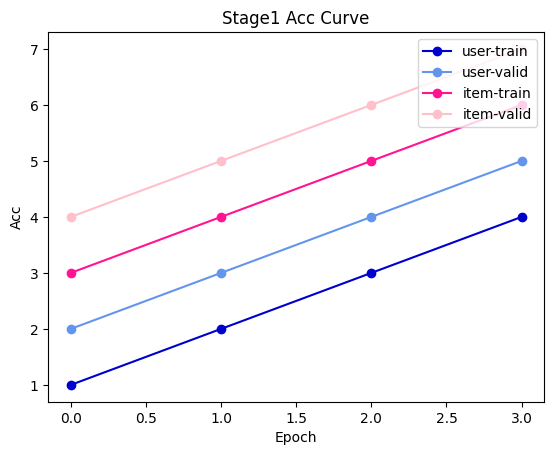

In [52]:
import matplotlib.pyplot as plt

t1 = [1,2,3,4]
v1 = [2,3,4,5]
t2 = [3,4,5,6]
v2 = [4,5,6,7]

# Plot test
def draw_acc_curve_stage1(u_train_acc, u_valid_acc, i_train_acc, i_valid_acc):
    plt.plot(u_train_acc, color="mediumblue", label="user-train", marker='o')
    plt.plot(u_valid_acc, color="cornflowerblue", label="user-valid", marker='o')
    plt.plot(i_train_acc, color="deeppink", label="item-train", marker='o')
    plt.plot(i_valid_acc, color="pink", label="item-valid", marker='o')
    plt.legend(loc="upper right")
    plt.xlabel("Epoch")
    plt.ylabel("Acc")
    plt.title(f"Stage1 Acc Curve")
    # plt.savefig('output/plot/collab/acc_stage1_{}.png'.format(time.strftime("%m%d%H%M%S")))
    plt.show()

draw_acc_curve_stage1(t1,v1, t2, v2)